<a href="https://colab.research.google.com/github/WadeShadow/nlp2021/blob/main/Exam/Brekht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Брехт Андрій Олексійович
---
### Група: ТШІ-21
### Варіант: 2
---
### Практичне завдання іспиту з дисципліни "Методи обробки природномовної інформації"
### Дата складання: 13.12.2021р.

---
Варіант № 2

Завдання:
Розробити Jupyter Notebook для вирішення завдання класифікації тексту
на основі набору даних:
https://drive.google.com/drive/folders/1cYLsyazwxMUSICumvIhv5jGJe6K7iAHa?usp=sharing

Забезпечити виконання наступних етапів:
1. Завантаження та попередній аналіз даних.
2. Створення тренувального та тестувального наборів даних.
3. Попередню оцінку точності моделі за допомогою методу Naive Bayes.
4. Вирішення задачі класифікації за допомогою методу GRU model.
5. Графічне відображення тренування моделі.
6. Порівняння результатів, отриманих у п.п. 3,4
7. Висновки.

Структура звітного документу:
Заголовок роботи (Markdown: П.І.Б., група, назва роботи (Практичне завдання іспиту з дисципліни...), дата складання.)
Етапи роботи (Номер та назва етапу (частини етапу),  код з коментарями.)

Використати технології: Tensorflow, Google Colab.
Результати викласти у форматі Brekht.ipynb у папку Exam репозиторію GitHub.

#Завантаження та попердній аналіз даних

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf, requests as rqst, io
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

rnd = np.random.randint

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-12-13 08:14:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-13 08:14:14 (68.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
file = open('train_new.csv','r')
new_file = open('train_new1.csv', 'w')
for i, line in enumerate(file):
  if i>930 and i<940:
    continue
  new_file.write(line)

In [ ]:
training_data = pd.read_csv('train.csv', engine='python', error_bad_lines=False)
val_data = pd.read_csv('valid.csv', engine='python', error_bad_lines=False)
training_data
val_data

Skipping line 937: unexpected end of data
Skipping line 1017: unexpected end of data


,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
1010,35745067,regex extract a text between string,<p>are not so expert with regex\ni have this s...,<regex><vb.net>,2016-03-02 10:50:27,LQ_CLOSE
1011,35747862,what does _doc represents in elasticsearch?,<p>I am still trying to figure out what does _...,<elasticsearch>,2016-03-02 12:56:10,HQ
1012,35748116,Babel ignore several directories,<p>I'm currently running Babel with a simple c...,<javascript><babeljs>,2016-03-02 13:07:57,HQ
1013,35750407,PHP Sanitise Data,<p>Can't seem to sanitise php data</p>\n\n<pre...,<php><mysql>,2016-03-02 14:44:23,LQ_CLOSE


In [ ]:
training_data['Predict'] = training_data['Y']
val_data['Predict'] = val_data['Y']

training_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)
val_data.replace({'Predict':{'LQ_EDIT':0,'HQ':1, 'LQ_CLOSE':2}}, inplace=True)

training_data['Body'] = training_data['Title']+':::'+training_data['Body']

training_data

,Id,Title,Body,Tags,CreationDate,Y,Predict
0,34552656,Java: Repeat Task Every Random Seconds,Java: Repeat Task Every Random Seconds:::<p>I'...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,2
1,34553034,Why are Java Optionals immutable?,Why are Java Optionals immutable?:::<p>I'd lik...,<java><optional>,2016-01-01 02:03:20,HQ,1
2,34553174,Text Overlay Image with Darkened Opacity React...,Text Overlay Image with Darkened Opacity React...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,1
3,34553318,Why ternary operator in swift is so picky?,Why ternary operator in swift is so picky?:::<...,<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,1
4,34553755,hide/show fab with scale animation,hide/show fab with scale animation:::<p>I'm us...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,1
...,...,...,...,...,...,...,...
930,34892541,"Notice ""Undifined Variable""","Notice ""Undifined Variable"":::<p>I am running ...",<php>,2016-01-20 05:57:59,LQ_CLOSE,2
931,34892601,what does the weak_alias function do and where...,what does the weak_alias function do and where...,<c><linux><gcc><compiler-construction><gnu>,2016-01-20 06:02:20,HQ,1
932,34892696,how to show selected item in another activityi...,how to show selected item in another activityi...,<android>,2016-01-20 06:08:02,LQ_CLOSE,2
933,34893279,Spring Data Redis Expire Key,Spring Data Redis Expire Key:::<p>I have a One...,<java><spring><hibernate><redis>,2016-01-20 06:49:25,HQ,1


#Створення тренувального та тестувального наборів даних + Векторизація та Ембедінг

In [ ]:
train_set = training_data[['Body','Predict']].sample(frac=1)
val_set = val_data[['Body','Predict']].sample(frac=1)
train_set

,Body,Predict
435,Adding variables to dictionary:::<p>I have a e...,2
237,IE-9 giving fakepath when using input type fil...,2
178,Is it possible to set a hostname in a Kubernet...,1
376,how to avoid java.util.zip.ZipException in and...,0
523,Illegal instruction (core dumped) neural netwo...,0
...,...,...
128,Why does Shake recommend disabling idle garbag...,1
231,Python equivalent of golang's defer statement:...,1
634,How to assign a variable in a Swift case state...,1
368,Wordpress REST API (wp-api) 404 Error:::<p>I h...,1


In [ ]:
avg_length = round(sum([len(i.split()) for i in train_set['Body']])/len(train_set))
avg_length

121

In [ ]:
max_vocab_length = 10000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=avg_length)

text_vectorizer.adapt(train_set['Body'])

text_vectorizer(train_set['Body'])

<tf.Tensor: shape=(935, 121), dtype=int64, numpy=
array([[ 591,  547,    3, ...,    0,    0,    0],
       [3445,  942,    1, ...,    0,    0,    0],
       [   7,   10,  173, ...,    0,    0,    0],
       ...,
       [  21,    3,  963, ...,    0,    0,    0],
       [1357,  426,  275, ..., 2642,  803,   27],
       [ 335, 3515,  876, ...,   66,    7,  269]])>

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform",
                             input_length=avg_length) 

embedding(text_vectorizer(train_set['Body']))

<tf.Tensor: shape=(935, 121, 128), dtype=float32, numpy=
array([[[-2.42964625e-02, -3.99389490e-02, -8.74741003e-03, ...,
          3.98504771e-02,  4.12590168e-02, -2.46222615e-02],
        [-1.21223219e-02,  3.90159599e-02,  2.33254470e-02, ...,
          4.09330763e-02,  1.98102035e-02, -4.85712551e-02],
        [ 3.30203772e-03,  4.17785980e-02,  3.92936543e-03, ...,
          1.43011250e-02,  4.38874625e-02, -3.60896699e-02],
        ...,
        [ 3.08134072e-02,  4.02654670e-02,  4.74383272e-02, ...,
         -3.07097081e-02, -3.94781232e-02, -4.86877225e-02],
        [ 3.08134072e-02,  4.02654670e-02,  4.74383272e-02, ...,
         -3.07097081e-02, -3.94781232e-02, -4.86877225e-02],
        [ 3.08134072e-02,  4.02654670e-02,  4.74383272e-02, ...,
         -3.07097081e-02, -3.94781232e-02, -4.86877225e-02]],

       [[ 3.20196413e-02, -3.00221331e-02, -7.17378780e-03, ...,
          1.46403164e-03,  4.10903133e-02,  1.41555928e-02],
        [ 4.74168994e-02, -4.81607430e-02,  1.

#Попередню оцінка точності моделі за допомогою методу Naive Bayes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])

model_0.fit(train_set['Body'], train_set['Predict'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_set['Body'], val_set['Predict'])
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 45.12%


In [ ]:
baseline_preds = model_0.predict(val_set['Body'])
baseline_preds

array([1, 1, 1, ..., 1, 1, 1])

#Вирішення задачі класифікації за допомогою методу GRU

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(128)(x)
x = layers.Dense(128, activation="sigmoid")(x) 
outputs = layers.Dense(3, activation="softmax")(x)
model_gru = tf.keras.Model(inputs, outputs, name="model_GRU")

In [ ]:
model_gru.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_gru.summary()

Model: "model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 121)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 121, 128)          1280000   
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                         

In [ ]:
model_gru_history = model_gru.fit(train_set['Body'], train_set['Predict'],
                              epochs=30,
                              validation_data=(val_set['Body'], val_set['Predict']))

Epoch 1/30
30/30 [==============================] - 5s 72ms/step - loss: 1.0843 - accuracy: 0.4257 - val_loss: 1.0838 - val_accuracy: 0.4227
Epoch 2/30
30/30 [==============================] - 2s 51ms/step - loss: 1.0689 - accuracy: 0.4492 - val_loss: 1.0801 - val_accuracy: 0.4227
Epoch 3/30
30/30 [==============================] - 2s 52ms/step - loss: 1.0483 - accuracy: 0.4417 - val_loss: 1.0625 - val_accuracy: 0.4049
Epoch 4/30
30/30 [==============================] - 2s 51ms/step - loss: 0.9833 - accuracy: 0.4460 - val_loss: 1.0910 - val_accuracy: 0.4296
Epoch 5/30
30/30 [==============================] - 2s 51ms/step - loss: 0.9076 - accuracy: 0.5166 - val_loss: 1.0883 - val_accuracy: 0.4236
Epoch 6/30
30/30 [==============================] - 2s 52ms/step - loss: 0.8458 - accuracy: 0.5519 - val_loss: 1.0909 - val_accuracy: 0.4217
Epoch 7/30
30/30 [==============================] - 2s 52ms/step - loss: 0.8079 - accuracy: 0.5668 - val_loss: 1.1521 - val_accuracy: 0.4099
Epoch 8/30
30

In [ ]:
model_gru_pred_probs = model_gru.predict(val_set['Body'])

In [ ]:
model_gru_preds = tf.squeeze(tf.argmax(model_gru_pred_probs, axis = 1))
model_gru_preds

<tf.Tensor: shape=(1015,), dtype=int64, numpy=array([0, 1, 2, ..., 2, 2, 2])>

#Графічне відображення тренування моделі.

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

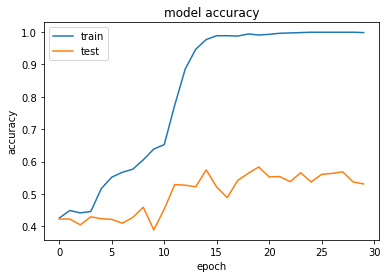

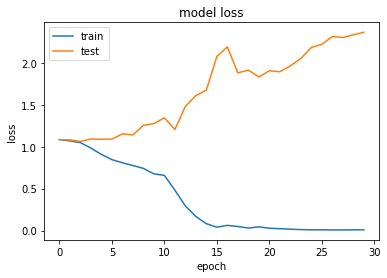

In [ ]:
plot_history(model_gru_history)

#Порівняння результатів моделей

In [ ]:
def compare_base_model_to_new_model(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Base model {key.upper()}: {value:.2f}, New model {key.upper()}: {new_model_results[key]:.2f}, Relative Improvement: {(new_model_results[key]/value-1)*100:.1f}%")

In [ ]:
baseline_results = calculate_results(y_true=val_set['Predict'],
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 45.1231527093596,
 'f1': 0.31185835653601773,
 'precision': 0.622423645320197,
 'recall': 0.45123152709359604}

In [ ]:
model_gru_results = calculate_results(y_true=val_set['Predict'],
                                    y_pred=model_gru_preds)
model_gru_results

{'accuracy': 53.103448275862064,
 'f1': 0.5316299143280292,
 'precision': 0.6051629562332932,
 'recall': 0.5310344827586206}

In [ ]:
compare_base_model_to_new_model(baseline_results, model_gru_results)

Base model ACCURACY: 45.12, New model ACCURACY: 53.10, Relative Improvement: 17.7%
Base model PRECISION: 0.62, New model PRECISION: 0.61, Relative Improvement: -2.8%
Base model RECALL: 0.45, New model RECALL: 0.53, Relative Improvement: 17.7%
Base model F1: 0.31, New model F1: 0.53, Relative Improvement: 70.5%
